# Transform into a DataFrame logs data.


In [2]:
import os
import json
import pandas as pd

# Directory where your JSON log files are stored.
CURRENT_DIR = os.getcwd()
LOGS_DIR = os.path.join(CURRENT_DIR, "dataset/logs")

# Lists to store extracted game-level and round-level data.
games_data = []
choices_data = []

# Iterate over all files in the logs folder.
for filename in os.listdir(LOGS_DIR):
    if filename.endswith('.json'):
        file_path = os.path.join(LOGS_DIR, filename)
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Parse game-level data.
        game_id = data.get("game_id")
        start_time = pd.to_datetime(data.get("start_time"), utc=True)
        completion_time = pd.to_datetime(data.get("completion_time"), utc=True) if data.get("completion_time") else None
        total_duration = data.get("total_duration")
        success = data.get("success")
        
        
        # Retrieve final_choice: either as a top-level key or from within choices.
        final_choice_data = data.get("final_choice")
        if not final_choice_data:
            # Look for an entry in choices with "type": "final_choice".
            for choice in data.get("choices", []):
                if choice.get("type") == "final_choice":
                    final_choice_data = choice
                    break

        if final_choice_data:
            chosen_quadrant = final_choice_data.get("chosen_quadrant")
            correct = final_choice_data.get("correct")
            score = final_choice_data.get("score")
            biased_quadrant = final_choice_data.get("biased_quadrant")
        else:
            chosen_quadrant = None
            correct = None
            score = None
            biased_quadrant = None
            
            
        if "total_duration" not in data or "completion_time" not in data or "success" not in data or "start_time" not in data or "game_id" not in data or not final_choice_data or not data.get("choices"):
            # print(filename)
            continue
        
        games_data.append({
            "game_id": game_id,
            "start_time": start_time,
            "completion_time": completion_time,
            "total_duration": total_duration,
            "success": success,
            "chosen_quadrant": chosen_quadrant,
            "correct": correct,
            "score": score,
            "biased_quadrant": biased_quadrant,
            "source_file": filename  # Track the source file if needed.
        })
        
        # Process each entry in the choices list.
        for choice in data.get("choices", []):
            # Skip the final_choice entry if it was provided inside choices.
            if choice.get("type") == "final_choice":
                continue

            round_num = choice.get("round")
            quadrant = choice.get("quadrant")
            # Use "cue_name" if available; otherwise fallback to "choice".
            cue_name = choice.get("cue_name") if "cue_name" in choice else choice.get("choice")
            color = choice.get("color")
            timestamp = pd.to_datetime(choice.get("timestamp"), utc=True) if choice.get("timestamp") else None

            choices_data.append({
                "game_id": game_id,
                "round": round_num,
                "quadrant": quadrant,
                "cue_name": cue_name,
                "color": color,
                "timestamp": timestamp,
            })

# Convert the lists to pandas DataFrames for further analysis.
games_df = pd.DataFrame(games_data)
choices_df = pd.DataFrame(choices_data)

# Map quadrant values from [0, 1, 2, 3] to [A, B, C, D].
quadrant_mapping = {0: "A", 1: "B", 2: "C", 3: "D"}
games_df["chosen_quadrant"] = games_df["chosen_quadrant"].map(quadrant_mapping)
games_df["biased_quadrant"] = games_df["biased_quadrant"].map(quadrant_mapping)

print("Choices DataFrame:")
choices_df.rename(columns={'cue_name': 'chosen_quadrant'}, inplace=True)
choices_df.drop(columns=['quadrant'], inplace=True)

display(choices_df)

# Drop and rename columns as needed.
games_df.rename(columns={'cue_name': 'quadrant'}, inplace=True)

print("Games DataFrame:")
display(games_df.sort_values(by="total_duration", ascending=False))

Choices DataFrame:


,game_id,round,chosen_quadrant,color,timestamp
0,153f891f-9273-4bc4-a0d6-f78e8f6981df,0,A,RED,2025-02-13 13:26:31.236000+00:00
1,153f891f-9273-4bc4-a0d6-f78e8f6981df,1,A,RED,2025-02-13 13:26:32.951000+00:00
2,153f891f-9273-4bc4-a0d6-f78e8f6981df,2,A,RED,2025-02-13 13:26:34.484000+00:00
3,f32696f2-9de2-4678-8493-0afe7b692f10,0,A,GREEN,2025-02-13 13:42:55.232000+00:00
4,f32696f2-9de2-4678-8493-0afe7b692f10,1,B,RED,2025-02-13 13:42:58.303000+00:00
...,...,...,...,...,...
903,dc7af284-a056-4a87-bfe0-bd20f87fada9,9,B,GREEN,2025-02-11 15:13:33.416000+00:00
904,dc7af284-a056-4a87-bfe0-bd20f87fada9,10,C,GREEN,2025-02-11 15:13:35.602000+00:00
905,dc7af284-a056-4a87-bfe0-bd20f87fada9,11,A,GREEN,2025-02-11 15:13:37.179000+00:00
906,d6cc47bf-a62d-4e8a-9a3e-67f55a481ce6,0,D,GREEN,2025-02-14 14:52:22.987000+00:00


Games DataFrame:


,game_id,start_time,completion_time,total_duration,success,chosen_quadrant,correct,score,biased_quadrant,source_file
16,c8c3b5bb-68cf-4657-807c-7590a0579954,2025-02-13 13:32:26.384222+00:00,2025-02-13 13:45:55.615268+00:00,809.231046,False,D,False,-100,A,game_c8c3b5bb-68cf-4657-807c-7590a0579954.json
34,f863e848-387d-40e1-a4fa-9064e76bfc4d,2025-02-14 20:39:47.852554+00:00,2025-02-14 20:43:56.132081+00:00,248.279527,False,C,False,-100,A,game_f863e848-387d-40e1-a4fa-9064e76bfc4d.json
117,b12cf7e4-8125-4e4c-b038-923fa3c1e645,2025-02-13 13:27:26.931351+00:00,2025-02-13 13:31:30.329723+00:00,243.398372,True,C,True,100,C,game_b12cf7e4-8125-4e4c-b038-923fa3c1e645.json
9,f20d9df6-966b-42c9-9564-5a227e447a0e,2025-02-13 17:08:53.135000+00:00,2025-02-13 17:12:22.773551+00:00,209.638551,True,A,True,100,A,game_f20d9df6-966b-42c9-9564-5a227e447a0e.json
110,91d38a41-a495-4e58-9d00-1de2e86b6d43,2025-02-13 13:32:04.375602+00:00,2025-02-13 13:34:42.449000+00:00,158.073398,True,D,True,100,D,game_91d38a41-a495-4e58-9d00-1de2e86b6d43.json
...,...,...,...,...,...,...,...,...,...,...
6,d69294e8-731e-447f-9f4a-c3e80a08b56d,2025-02-13 14:35:32.302014+00:00,2025-02-13 14:35:38.365003+00:00,6.062989,True,B,True,100,B,game_d69294e8-731e-447f-9f4a-c3e80a08b56d.json
105,9896a898-ac4d-46b7-94db-7192058c50ff,2025-02-10 17:24:38.261393+00:00,2025-02-10 17:24:44.254338+00:00,5.992945,False,B,False,-100,A,game_9896a898-ac4d-46b7-94db-7192058c50ff.json
12,59be0148-38f2-44e5-a7c6-24614d0d6c8a,2025-02-13 13:31:33.182401+00:00,2025-02-13 13:31:38.009506+00:00,4.827105,False,C,False,-100,D,game_59be0148-38f2-44e5-a7c6-24614d0d6c8a.json
94,9b377a61-f5f5-476c-8dfc-8c5073f33db2,2025-02-13 13:24:25.341565+00:00,2025-02-13 13:24:29.797917+00:00,4.456352,False,C,False,-100,D,game_9b377a61-f5f5-476c-8dfc-8c5073f33db2.json


# Games DataFrame Visualiation


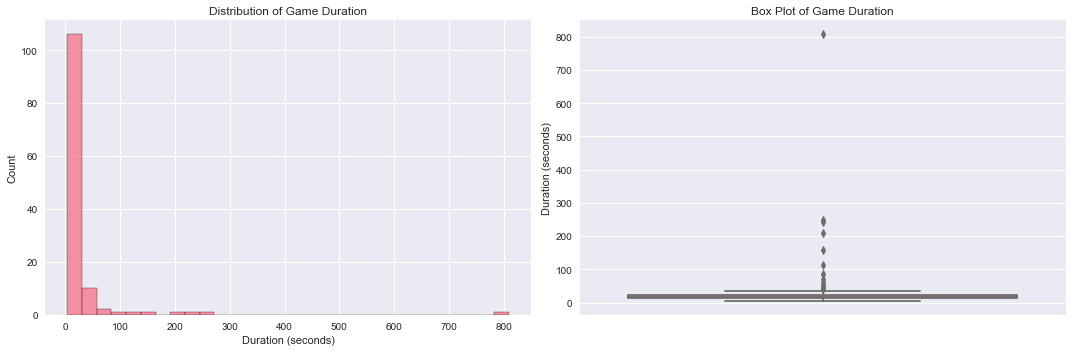


Duration Statistics:
Mean duration: 32.53 seconds
Median duration: 16.89 seconds
Min duration: 3.56 seconds
Max duration: 809.23 seconds
Standard deviation: 79.69 seconds
Filtered out 1 outliers (>3 std dev from mean) in 'total_duration'


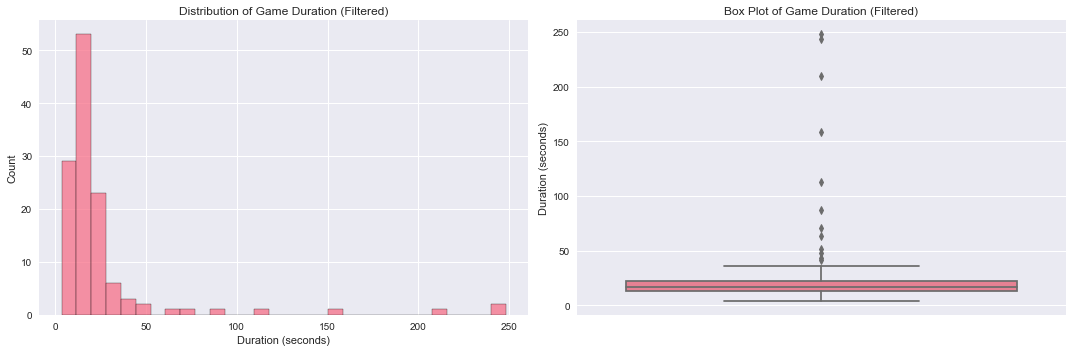


Filtered Duration Statistics:
Mean duration: 26.27 seconds
Median duration: 16.80 seconds
Min duration: 3.56 seconds
Max duration: 248.28 seconds
Standard deviation: 38.19 seconds
Z-score filter applied: removed 1 outliers from 'total_duration' (|Z| > 3.0)


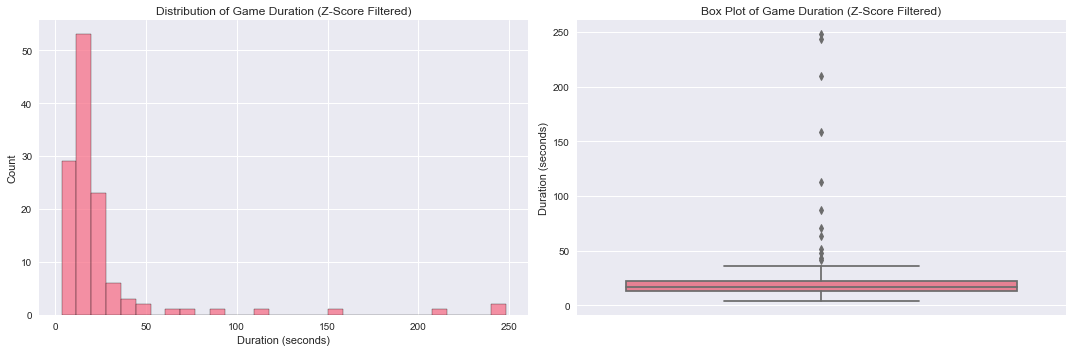


Filtered Duration Statistics (Z-Score):
Mean duration: 26.27 seconds
Median duration: 16.80 seconds
Min duration: 3.56 seconds
Max duration: 248.28 seconds
Standard deviation: 38.19 seconds


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



from scipy.stats import zscore

def filter_outliers_zscore(df, column, threshold=3.0):
    """
    Filters out rows in a DataFrame where the absolute Z-score of the given column exceeds the threshold.

    Returns:
        - A DataFrame with outliers removed
        - A DataFrame of just the outliers
    """
    df_clean = df[df[column].notnull()].copy()
    df_clean["z_score"] = zscore(df_clean[column])

    outliers = df_clean[abs(df_clean["z_score"]) > threshold]
    filtered_df = df_clean[abs(df_clean["z_score"]) <= threshold].drop(columns="z_score")

    print(f"Z-score filter applied: removed {len(outliers)} outliers from '{column}' (|Z| > {threshold})")
    return filtered_df, outliers


# Set style for better visualization
plt.style.use('seaborn')
sns.set_palette("husl")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
sns.histplot(data=games_df, x="total_duration", bins=30, ax=ax1)
ax1.set_title("Distribution of Game Duration")
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("Count")

# Box plot
sns.boxplot(data=games_df, y="total_duration", ax=ax2)
ax2.set_title("Box Plot of Game Duration")
ax2.set_ylabel("Duration (seconds)")

plt.tight_layout()
plt.show()

# Print some basic statistics
print("\nDuration Statistics:")
print(f"Mean duration: {games_df['total_duration'].mean():.2f} seconds")
print(f"Median duration: {games_df['total_duration'].median():.2f} seconds")
print(f"Min duration: {games_df['total_duration'].min():.2f} seconds")
print(f"Max duration: {games_df['total_duration'].max():.2f} seconds")
print(f"Standard deviation: {games_df['total_duration'].std():.2f} seconds")



filtered_games_df, duration_outliers = filter_outliers_zscore(games_df, "total_duration", threshold=3.0)

ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=filtered_games_df, x="total_duration", bins=30, ax=ax1)
ax1.set_title("Distribution of Game Duration (Z-Score Filtered)")
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("Count")

sns.boxplot(data=filtered_games_df, y="total_duration", ax=ax2)
ax2.set_title("Box Plot of Game Duration (Z-Score Filtered)")
ax2.set_ylabel("Duration (seconds)")

plt.tight_layout()
plt.show()

# Print descriptive stats
print("\nFiltered Duration Statistics (Z-Score):")
print(f"Mean duration: {filtered_games_df['total_duration'].mean():.2f} seconds")
print(f"Median duration: {filtered_games_df['total_duration'].median():.2f} seconds")
print(f"Min duration: {filtered_games_df['total_duration'].min():.2f} seconds")
print(f"Max duration: {filtered_games_df['total_duration'].max():.2f} seconds")
print(f"Standard deviation: {filtered_games_df['total_duration'].std():.2f} seconds")